Preproces data for computing pca during test period

trial_error:
* 0: correct trial
* 6: false alarm (relase during test period)
* 8: missed target

In [1]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import get_neuron_sample_test_fr, to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.trials.spikes import firing_rate
import matplotlib.pyplot as plt
from ephysvibe.task import task_constants

In [2]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz,ss

In [3]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp)
    # C = model.components_
    # pc_s = C @ x
    pc_s = model.fit_transform(x.T).T
    return model, pc_s

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
# Define parameters
filepaths = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/"
outputpath = "./test/"

area = "lip"
subject = "Riesling"
avgwin = 100
min_sp_sec = 5
n_test = 1
min_trials = 10
nonmatch = True  # if True: includes nonmatch trials

# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400

# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# -------------------------------------------- End parameters ------------------------------------------

# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test


In [2]:
def get_trials_by_perf(path,sp_sample=False):
    name_code = {3:'hit',2:'false_alarm', 1: 'miss', 0: 'correct_rejection'}
    neu = NeuronData.from_python_hdf5(path)
    b1mask = neu.block==1
    performance = neu.get_performance()
    time_before=500
    tests_tr = neu.get_tests_tr_bhv_clasification(sp=neu.sp_samples[b1mask],
                                            performance=performance,
                                            codes=[3,1,2,0],
                                            code_samples=neu.code_samples[b1mask],
                                            code_numbers=neu.code_numbers[b1mask],
                                            time_before=time_before,
                                            name_code=name_code)
    
    for key in tests_tr.keys():
        setattr(neu, key, tests_tr[key])
    if ~sp_sample:
        setattr(neu, "sp_samples", np.array([]))
    return neu

In [31]:
filepaths = {
    #"lip": 'D:/data/session_struct/lip/neurons/',
    # "pfc":'D:/data/session_struct/pfc/neurons/',
    "v4": 'D:/data/session_struct/v4/neurons/',
}

In [32]:
outputpath='./'
for area in filepaths.keys():
    print(area)
    neu_path = filepaths[area] + "*neu.h5"
    path_list = glob.glob(neu_path)

    population = Parallel(n_jobs=-1)(
        delayed(get_trials_by_perf)(path, False) for path in tqdm(path_list)
    )
    popu = PopulationData(population, comment=' ')
    popu.to_python_hdf5(outputpath + "testdata_for_pca_" + area + ".h5")
    

v4


100%|██████████| 1078/1078 [04:24<00:00,  4.07it/s]


In [57]:
neu.false_alarm_pos

array([1, 1, 3, 0, 2, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 3, 2, 1, 2, 4, 0, 2,
       2, 2, 2, 0, 1, 0, 3, 1], dtype=int64)

In [65]:
def compute_fr(neu):
    avgwin=100
    miss = firing_rate.moving_average(
        neu.miss[neu.miss_pos!=0], win=avgwin, step=1
    )[:,50:-50]
    miss_avg = np.mean(miss,axis=0)
    hit = firing_rate.moving_average(
        neu.hit[neu.hit_pos!=0], win=avgwin, step=1
    )[:,50:-50]
    hit_avg = np.mean(hit,axis=0)
    correct_rejection = firing_rate.moving_average(
        neu.correct_rejection[neu.correct_rejection_pos!=0], win=avgwin, step=1
    )[:,50:-50]
    correct_rejection_avg = np.mean(correct_rejection,axis=0)
    false_alarm = firing_rate.moving_average(
        neu.false_alarm[neu.false_alarm_pos!=0], win=avgwin, step=1
    )[:,50:-50]
    false_alarm_avg = np.mean(false_alarm,axis=0)
    
    checkfr = np.any([np.mean(miss_avg)*1000>5,np.mean(hit_avg)*1000>5,np.mean(correct_rejection_avg)*1000>5,np.mean(false_alarm_avg)*1000>5])
    checkntr = np.all([miss.shape[0]>25,hit.shape[0]>25,correct_rejection.shape[0]>25,false_alarm.shape[0]>25])
    if np.logical_and(checkfr,checkntr): 
        concat = np.concatenate([miss_avg,hit_avg,correct_rejection_avg,false_alarm_avg])
        return concat

    # else:
    #     f,ax = plt.subplots(1,4, figsize=(20,2),sharey=True)
    #     i=0
    #     for iname,idata in zip( ['miss','hit','correct_rejection','false_alarm'],[miss_avg,hit_avg,correct_rejection_avg,false_alarm_avg]):
    #         ax[i].plot(idata)
    #         ax[i].set_title(iname)
    #         ax[i].vlines(450,ax[i].get_ylim()[0],ax[i].get_ylim()[1],'k')
    #         i+=1

In [69]:
pcs_areas={}
for area in ['lip','v4','pfc']:
    popu = PopulationData.from_python_hdf5(outputpath + "testdata_for_pca_" + area + ".h5")
    allneu = Parallel(n_jobs=-1)(
        delayed(compute_fr)(neu) for neu in tqdm(popu.population)
    )

    allneu=np.array([i for i in allneu if i is not None])
    allneu=allneu.reshape(allneu.shape[0],4,-1)[:,:,250:450+350]
    allneu=allneu.reshape(allneu.shape[0],-1)
    n_comp=None
    model,pc_s = compute_pca(allneu,n_comp=n_comp)
    pcs_areas[area]=pc_s

100%|██████████| 1077/1077 [01:26<00:00, 12.46it/s]


In [72]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp).fit(x.T)
    C = model.components_
    pc_s = C @ x
    return model, pc_s

In [76]:
pcs_areas['pfc'].shape

(344, 2200)

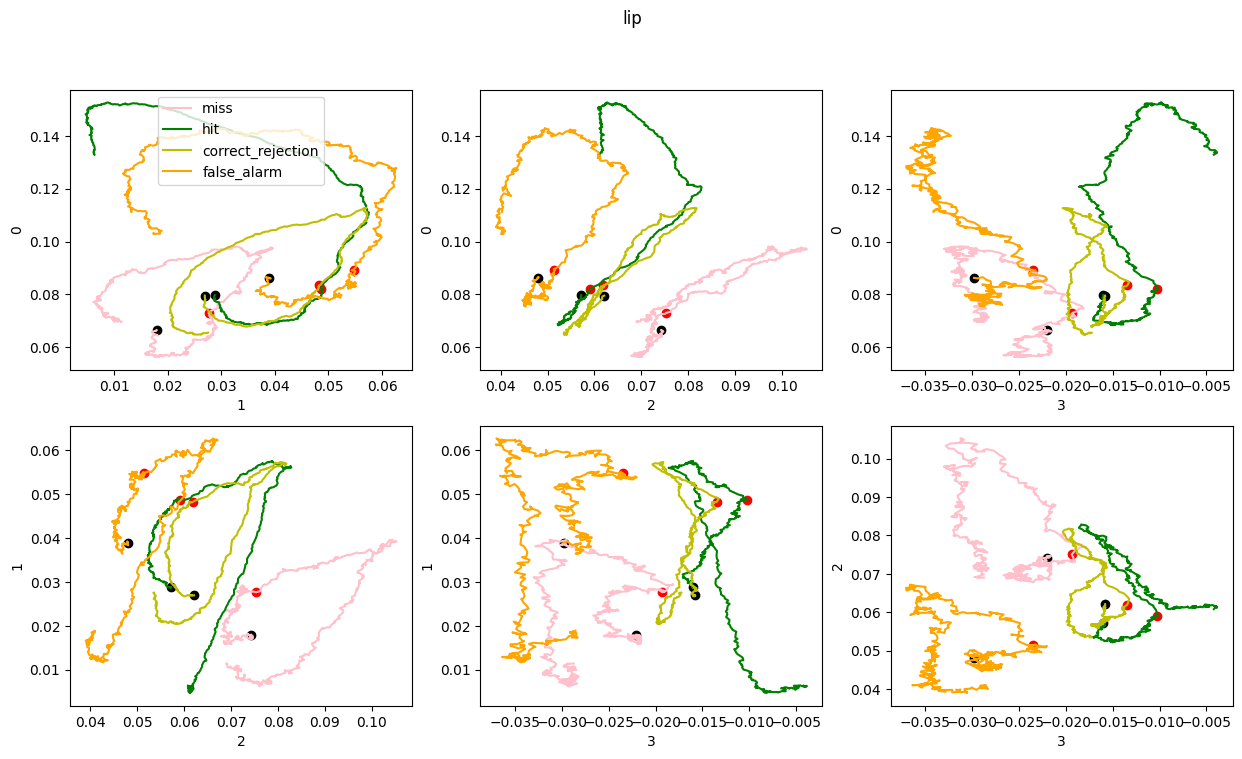

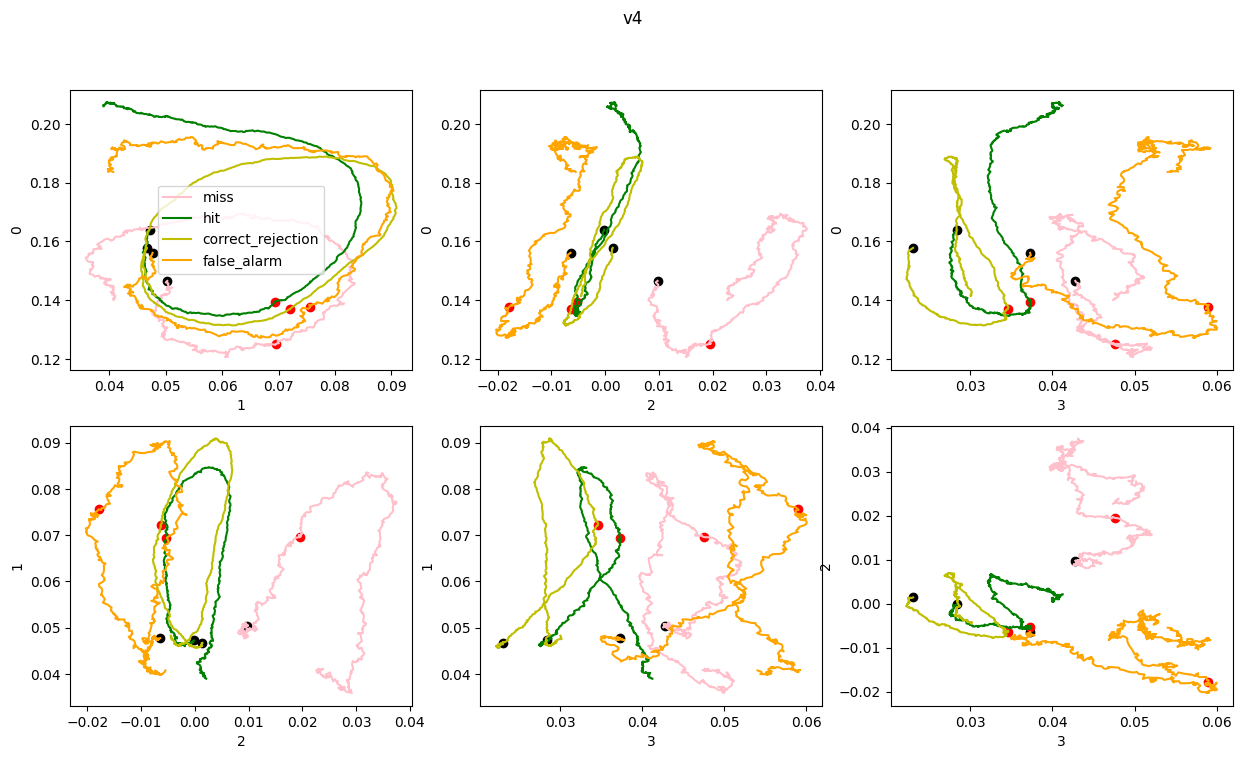

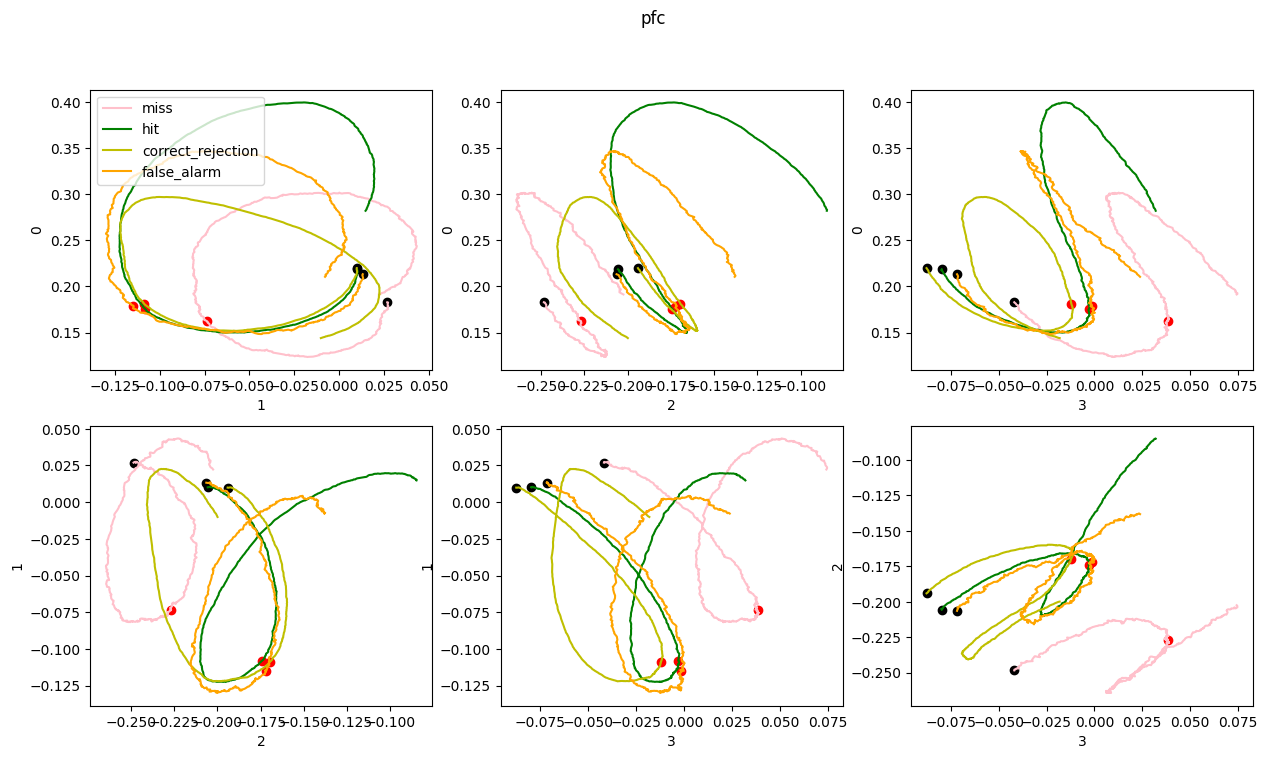

In [78]:

for area in ['lip','v4','pfc']:
    pc_s = pcs_areas[area]
    n_comp=pc_s.shape[0]
    reshape_pc_s = pc_s.reshape(n_comp,4,-1)
    f,ax=plt.subplots(2,3,figsize=(15,8))
    i_ax = 0
    j_ax = 0
    for j in range(0,4):
        for i in range(0 + j, 4):
            if i==j: continue
            if j_ax >= 3:
                i_ax = 1
                j_ax = 0
            ax[i_ax,j_ax].plot(reshape_pc_s[i,0][:450+600],reshape_pc_s[j,0][:450+600],color='pink',label='miss')
            ax[i_ax,j_ax].plot(reshape_pc_s[i,1][:450+600],reshape_pc_s[j,1][:450+600],color='g',label='hit')
            ax[i_ax,j_ax].plot(reshape_pc_s[i,2][:450+600],reshape_pc_s[j,2][:450+600],color='y',label='correct_rejection')
            ax[i_ax,j_ax].plot(reshape_pc_s[i,3][:450+600],reshape_pc_s[j,3][:450+600],color='orange',label='false_alarm')

            ax[i_ax,j_ax].scatter(reshape_pc_s[i,0][0],reshape_pc_s[j,0][0],color='k')
            ax[i_ax,j_ax].scatter(reshape_pc_s[i,1][0],reshape_pc_s[j,1][0],color='k')
            ax[i_ax,j_ax].scatter(reshape_pc_s[i,2][0],reshape_pc_s[j,2][0],color='k')
            ax[i_ax,j_ax].scatter(reshape_pc_s[i,3][0],reshape_pc_s[j,3][0],color='k')

            ax[i_ax,j_ax].scatter(reshape_pc_s[i,0][200],reshape_pc_s[j,0][200],color='r')
            ax[i_ax,j_ax].scatter(reshape_pc_s[i,1][200],reshape_pc_s[j,1][200],color='r')
            ax[i_ax,j_ax].scatter(reshape_pc_s[i,2][200],reshape_pc_s[j,2][200],color='r')
            ax[i_ax,j_ax].scatter(reshape_pc_s[i,3][200],reshape_pc_s[j,3][200],color='r')

            # ax[i_ax,j_ax].scatter(reshape_pc_s[i,0][500],reshape_pc_s[j,0][500],color='b')
            # ax[i_ax,j_ax].scatter(reshape_pc_s[i,1][500],reshape_pc_s[j,1][500],color='b')
            # ax[i_ax,j_ax].scatter(reshape_pc_s[i,2][500],reshape_pc_s[j,2][500],color='b')
            # ax[i_ax,j_ax].scatter(reshape_pc_s[i,3][500],reshape_pc_s[j,3][500],color='b')
            ax[i_ax,j_ax].set(xlabel=i,ylabel=j)
            j_ax += 1
    ax[0,0].legend()
    f.suptitle(area)